In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded 22865 images from the dataset.


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed

# Define paths
DATASET_PATH = "/content/drive/MyDrive/Pakistan Sign Language Urdu Alphabets"
CLASSES = [directory for directory in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, directory))]

# Initialize variables
image_size = (128, 128)  # Resized to 128x128 for faster processing
features = []
labels = []
original_images = []  # Store original images for visualization

# Function to process a single image and extract HOG features
def process_image(file_path, class_label):
    img = cv2.imread(file_path)
    if img is None:
        return None, None, None
    img_resized = cv2.resize(img, image_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    feature = hog(gray, pixels_per_cell=(32, 32), cells_per_block=(2, 2), visualize=False)
    return feature, class_label, img_resized

# Step 1: Load Dataset and Extract Features in Parallel
print("Loading dataset and extracting features...")
results = []
for class_label, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, class_name)
    file_paths = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path)]

    # Parallel processing for HOG extraction
    results += Parallel(n_jobs=-1)(delayed(process_image)(file_path, class_label) for file_path in file_paths)

# Filter out invalid results
results = [r for r in results if r[0] is not None]
features, labels, original_images = zip(*results)

# Convert to NumPy arrays
features = np.array(features)
labels = np.array(labels)

print(f"Loaded and processed {len(features)} images from the dataset.")






Loading dataset and extracting features...
Loaded and processed 22865 images from the dataset.


In [ ]:
print(CLASSES)

In [ ]:
---------------------------------------------------------------------------# Step 2: Split Dataset into Training and Testing
print("Splitting dataset into training and testing sets...")
X_train, X_test, y_train, y_test, orig_train, orig_test = train_test_split(
    features, labels, original_images, test_size=0.10, random_state=42, stratify=labels
)

print(f"Training set size: {len(X_train)} images.")
print(f"Testing set size: {len(X_test)} images.")

# Step 3: Train SVM Classifier
print("Training SVM classifier...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Step 4: Evaluate Model
print("Evaluating model on the test set...")
y_pred = svm_model.predict(X_test)

# Print accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CLASSES))

Splitting dataset into training and testing sets...
Training set size: 20578 images.
Testing set size: 2287 images.
Training SVM classifier...
Evaluating model on the test set...
Accuracy on test set: 94.53%
Classification Report:
              precision    recall  f1-score   support

       1-Hay       0.98      0.95      0.97        66
         Ain       0.95      0.95      0.95        59
        Alif       0.92      0.91      0.92        66
         Bay       0.96      0.96      0.96        69
        Byeh       0.98      0.96      0.97        56
        Chay       0.95      0.98      0.97        63
        Cyeh       0.95      0.95      0.95        56
        Daal       0.90      0.92      0.91        66
         Dal       0.96      0.95      0.96        58
    Dochahay       0.93      0.96      0.95        56
         Fay       0.98      0.95      0.97        59
        Gaaf       0.95      0.99      0.97       115
       Ghain       0.93      0.89      0.91        61
       Hamza

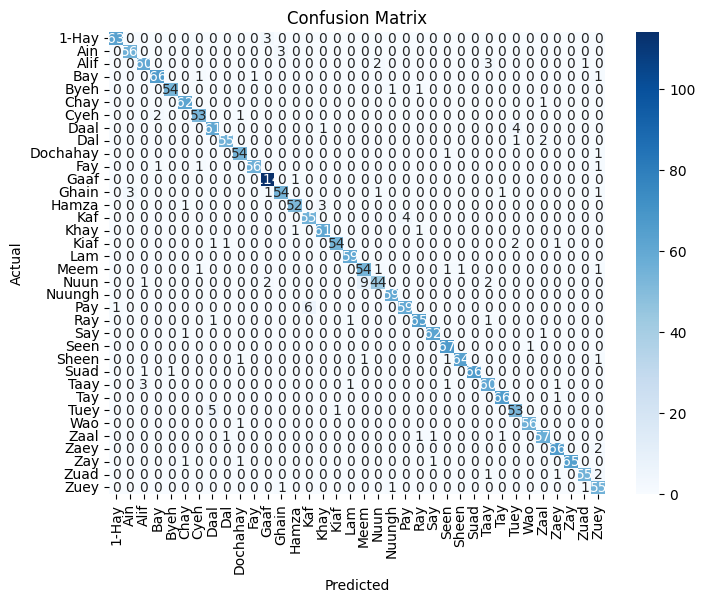

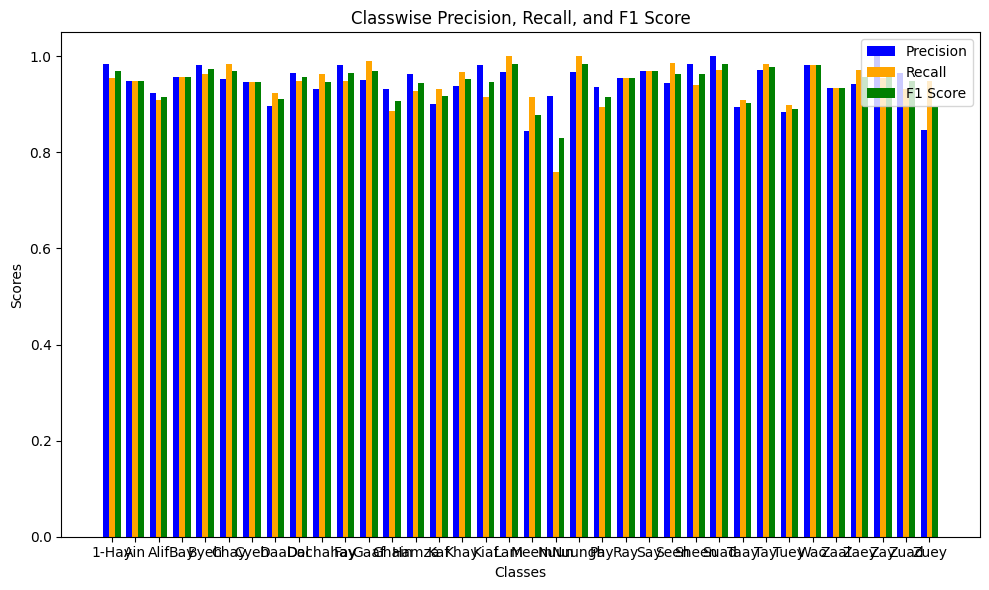

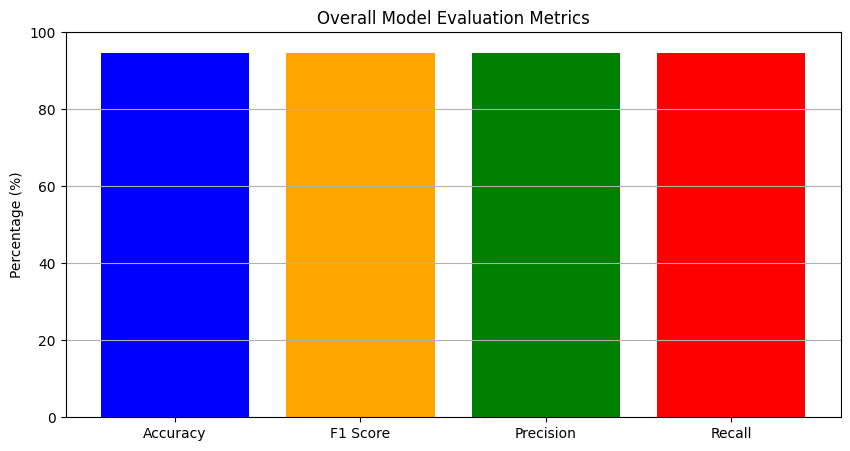

Saving the trained model...
Model saved successfully.


In [ ]:

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualization - Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization - Classwise Metrics
class_report = classification_report(y_test, y_pred, target_names=CLASSES, output_dict=True)

# Prepare data for plotting classwise metrics
class_names = list(class_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision_per_class = [class_report[name]['precision'] for name in class_names]
recall_per_class = [class_report[name]['recall'] for name in class_names]
f1_per_class = [class_report[name]['f1-score'] for name in class_names]

# Bar plots for classwise metrics
x = np.arange(len(class_names))
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', color='blue')
bars2 = ax.bar(x, recall_per_class, width, label='Recall', color='orange')
bars3 = ax.bar(x + width, f1_per_class, width, label='F1 Score', color='green')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classwise Precision, Recall, and F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

plt.tight_layout()
plt.show()

# Visualization - Overall Metrics
overall_metrics = {
    'Accuracy': accuracy,
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted')
}

plt.figure(figsize=(10, 5))
plt.bar(overall_metrics.keys(), [value * 100 for value in overall_metrics.values()], color=['blue', 'orange', 'green', 'red'])
plt.title("Overall Model Evaluation Metrics")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

# Save the model
print("Saving the trained model...")
joblib.dump(svm_model, "gesture_recognition_svm_model.pkl")
print("Model saved successfully.")

In [8]:
print(CLASSES)

['1-Hay', 'Ain', 'Alif', 'Bay', 'Byeh', 'Chay', 'Cyeh', 'Daal', 'Dal', 'Dochahay', 'Fay', 'Gaaf', 'Ghain', 'Hamza', 'Kaf', 'Khay', 'Kiaf', 'Lam', 'Meem', 'Nuun', 'Nuungh', 'Pay', 'Ray', 'Say', 'Seen', 'Sheen', 'Suad', 'Taay', 'Tay', 'Tuey', 'Wao', 'Zaal', 'Zaey', 'Zay', 'Zuad', 'Zuey']


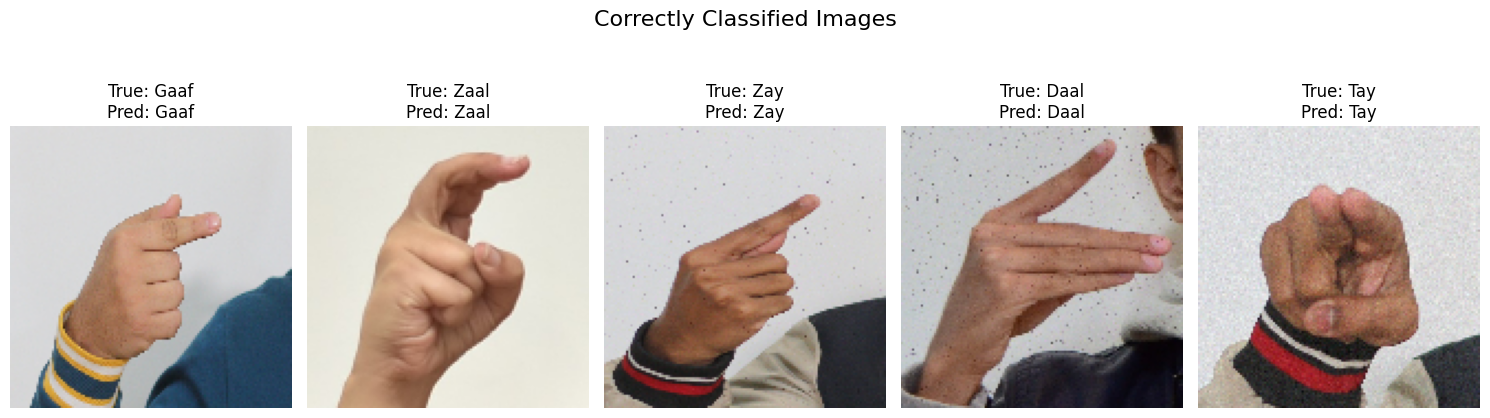

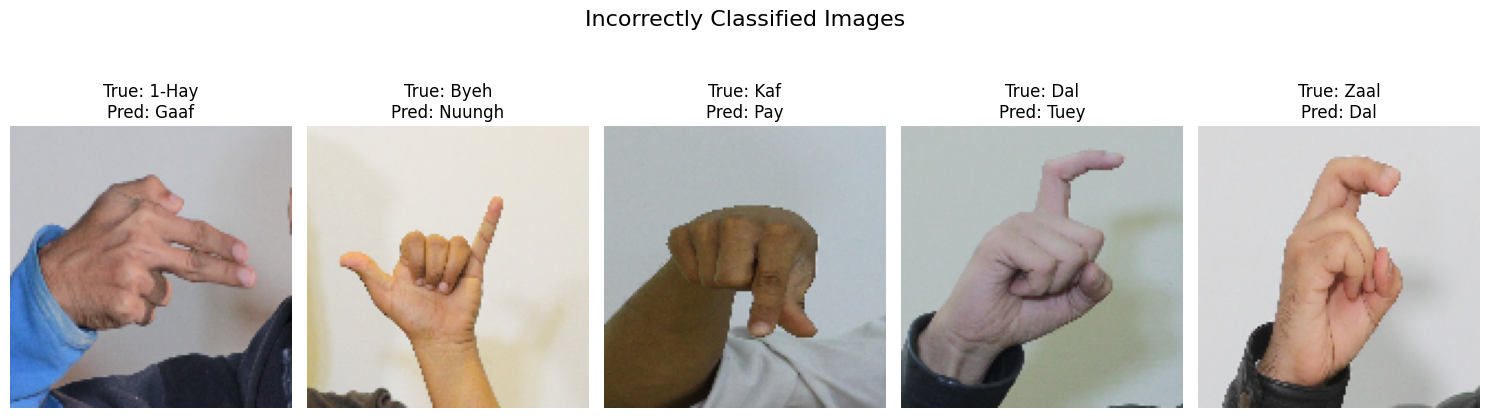

In [7]:
# Step 7: Display Example Images
def plot_examples(title, indices, y_true, y_pred, original_images, class_names, num_examples=5):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices[:num_examples]):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(cv2.cvtColor(original_images[idx], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot correctly classified examples
correct_indices = np.where(y_test == y_pred)[0]
plot_examples("Correctly Classified Images", correct_indices, y_test, y_pred, orig_test, CLASSES)

# Plot incorrectly classified examples
incorrect_indices = np.where(y_test != y_pred)[0]
plot_examples("Incorrectly Classified Images", incorrect_indices, y_test, y_pred, orig_test, CLASSES)

In [11]:
svm_model.save('gesture_recognition_model.h5')

AttributeError: 'SVC' object has no attribute 'save'

In [9]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import joblib

# Create a PDF file to save results
output_pdf_path = "gesture_recognition_results.pdf"
with PdfPages(output_pdf_path) as pdf:

    # Add accuracy and overall metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # First page: Overview of results
    plt.figure(figsize=(10, 6))
    plt.axis("off")
    text = (
        f"Gesture Recognition Results\n\n"
        f"Accuracy: {accuracy * 100:.2f}%\n"
        f"Precision (Weighted): {precision * 100:.2f}%\n"
        f"Recall (Weighted): {recall * 100:.2f}%\n"
        f"F1 Score (Weighted): {f1 * 100:.2f}%\n"
    )
    plt.text(0.1, 0.5, text, fontsize=14, va='center', wrap=True)
    pdf.savefig()  # Save page to PDF
    plt.close()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    pdf.savefig()  # Save confusion matrix
    plt.close()

    # Classwise Metrics
    class_report = classification_report(y_test, y_pred, target_names=CLASSES, output_dict=True)
    class_names = list(class_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    precision_per_class = [class_report[name]['precision'] for name in class_names]
    recall_per_class = [class_report[name]['recall'] for name in class_names]
    f1_per_class = [class_report[name]['f1-score'] for name in class_names]

    # Bar plots for classwise metrics
    x = np.arange(len(class_names))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, precision_per_class, width, label='Precision', color='blue')
    plt.bar(x, recall_per_class, width, label='Recall', color='orange')
    plt.bar(x + width, f1_per_class, width, label='F1 Score', color='green')
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Classwise Precision, Recall, and F1 Score')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    pdf.savefig()  # Save bar plots
    plt.close()

    # Overall Metrics Bar Plot
    overall_metrics = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }
    plt.figure(figsize=(10, 6))
    plt.bar(overall_metrics.keys(), [value * 100 for value in overall_metrics.values()], color=['blue', 'orange', 'green', 'red'])
    plt.title("Overall Model Evaluation Metrics")
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y')
    pdf.savefig()  # Save overall metrics
    plt.close()

    # Correctly Classified Examples
    def plot_examples(title, indices, y_true, y_pred, original_images, class_names, num_examples=5):
        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=16)
        for i, idx in enumerate(indices[:num_examples]):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(cv2.cvtColor(original_images[idx], cv2.COLOR_BGR2RGB))
            plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
            plt.axis("off")
        pdf.savefig()  # Save examples
        plt.close()

    # Correctly Classified Images
    correct_indices = np.where(y_test == y_pred)[0]
    plot_examples("Correctly Classified Images", correct_indices, y_test, y_pred, orig_test, CLASSES)

    # Incorrectly Classified Images
    incorrect_indices = np.where(y_test != y_pred)[0]
    plot_examples("Incorrectly Classified Images", incorrect_indices, y_test, y_pred, orig_test, CLASSES)

# Save the trained model
print("Saving the trained model...")
joblib.dump(svm_model, "gesture_recognition_svm_model.pkl")
print("Model saved successfully.")

print(f"Results saved to {output_pdf_path}")


Saving the trained model...
Model saved successfully.
Results saved to gesture_recognition_results.pdf


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Define class names corresponding to your new model's output classes
class_names = [
    '1-Hay', 'Ain', 'Alif', 'Bay', 'Byeh', 'Chay', 'Cyeh', 'Daal', 'Dal',
    'Dochahay', 'Fay', 'Gaaf', 'Ghain', 'Hamza', 'Kaf', 'Khay', 'Kiaf',
    'Lam', 'Meem', 'Nuun', 'Nuungh', 'Pay', 'Ray', 'Say', 'Seen', 'Sheen',
    'Suad', 'Taay', 'Tay', 'Tuey', 'Wao', 'Zaal', 'Zaey', 'Zay', 'Zuad', 'Zuey'
]

# Path to the image you want to predict
img_path = r"C:\Users\hp\OneDrive\Desktop\semester 7\computer vision\NewFace Mask Dataset\Correct\Train\Surgical\Child\FM 8346.jpg"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict with your new model
pred = model1.predict(img_array)  # Assuming model1 is your loaded new model
predicted_class_index = np.argmax(pred, axis=-1)[0]  # Get index of highest probability
predicted_label = class_names[predicted_class_index]  # Map to class name

# Print the predicted class
print(f"Predicted Class: {predicted_label}")